In [1]:
import json
import pandas as pd

讀取資料

In [2]:
with open('../data/output_clean_date_technical.json', 'r') as file:
    data = json.load(file)

攤平資料

In [3]:
merged_dict = {}

for item in data:
  if item == "historicalPriceFull":
    symbol = ""
    for entry in data[item]:
        if "symbol" in entry:
            symbol = data[item][entry]
        else:
            df = pd.json_normalize(data[item][entry])
            df["symbol"] = symbol
  else:
     df = pd.json_normalize(data[item])
  
  merged_dict[item] = df

In [4]:
merged_dict.keys()

dict_keys(['financialGrowth', 'ratios', 'cashFlowStatementGrowth', 'incomeStatementGrowth', 'balanceSheetStatementGrowth', 'historicalPriceFull', 'tech5', 'tech20', 'tech60', 'tech252'])

In [5]:
for k,v in merged_dict.items():
  print(k)
  print(v.head())

financialGrowth
    symbol        date calendarYear period  revenueGrowth  grossProfitGrowth  \
0  1101.TW  2023-10-30         2023     Q3      -0.024069          -0.035089   
1  1101.TW  2023-07-30         2023     Q2       0.052187           1.423824   
2  1101.TW  2023-04-30         2023     Q1      -0.241216          -0.523558   
3  1101.TW  2023-01-31         2022     Q4       0.113496           1.021971   
4  1101.TW  2022-10-30         2022     Q3       0.236128          22.238472   

   ebitgrowth  operatingIncomeGrowth  netIncomeGrowth  epsgrowth  ...  \
0   -0.181537              -0.181537        -0.647973  -0.622222  ...   
1    2.241177               2.241177         2.522023   2.214286  ...   
2   -0.571776              -0.571776        -0.595665  -0.611111  ...   
3    0.482921               0.482921         0.647513   0.636364  ...   
4    7.563693               7.563693         2.604780   2.571429  ...   

   tenYDividendperShareGrowthPerShare  fiveYDividendperShareGrow

將tech指數合併

In [ ]:
tech_merged_df = pd.DataFrame()
for k, v in merged_dict.items():
    if k.startswith("tech"):
        v["symbol"] = k
        tech_merged_df = pd.concat([tech_merged_df, v])
merged_dict["techIndex"] = tech_merged_df

In [ ]:
for k,v in merged_dict.items():
  print(k)
  print(v.head())

---

## 時間序列

使用過去股價，預設之後股價

In [6]:
merged_dict["historicalPriceFull"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              736 non-null    object 
 1   open              736 non-null    float64
 2   high              736 non-null    float64
 3   low               736 non-null    float64
 4   close             736 non-null    float64
 5   adjClose          736 non-null    float64
 6   volume            736 non-null    int64  
 7   unadjustedVolume  736 non-null    int64  
 8   change            736 non-null    float64
 9   changePercent     736 non-null    float64
 10  vwap              736 non-null    float64
 11  label             736 non-null    object 
 12  changeOverTime    736 non-null    float64
 13  symbol            736 non-null    object 
dtypes: float64(9), int64(2), object(3)
memory usage: 80.6+ KB


In [15]:
historical_df = merged_dict["historicalPriceFull"]

### prophet
https://github.com/facebook/prophet

code reference: https://medium.com/@aamurtazin/predicting-stock-market-with-python-3ce9fcbe23b2

In [8]:
from typing import List

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
    df = df[["date", "close"]]
    df.rename(columns={'date': 'ds', 'close': 'y'}, inplace=True)
    df = df.sort_values(by="ds", ascending=True).reset_index(drop=True)
    return df

def split_data(df: pd.DataFrame, test_size: float = 0.2) -> List[pd.DataFrame]:
    train_df = df.iloc[:int(len(df) * (1 - test_size))]
    test_df = df.iloc[int(len(df) * (1 - test_size)):]

    train_df = train_df.sort_values(by="ds", ascending=True).reset_index(drop=True)
    test_df = test_df.sort_values(by="ds", ascending=True).reset_index(drop=True)
    return train_df, test_df



In [9]:
df = preprocess_data(historical_df)
train_df, test_df = split_data(df)
print(f"training data size: {len(train_df)}, test data size: {len(test_df)}")

training data size: 588, test data size: 148


/tmp/ipykernel_9390/474850258.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'date': 'ds', 'close': 'y'}, inplace=True)


In [10]:
from prophet import Prophet

In [222]:
import holidays

# 获取所有支持的国家和地区
supported_countries = holidays.list_supported_countries()
# print(supported_countries)

# 获取台湾的节假日
tw_holidays = holidays.Taiwan(years=[2020, 2021, 2022, 2023])

# 将节假日转换为 DataFrame
holiday_df = pd.DataFrame(list(tw_holidays.items()), columns=['ds', 'holiday'])

# 添加周末为假期
weekends = pd.date_range(start='2020-01-01', end='2023-12-31', freq='W-SAT').tolist() + \
           pd.date_range(start='2020-01-01', end='2023-12-31', freq='W-SUN').tolist()
weekend_df = pd.DataFrame(weekends, columns=['ds'])
weekend_df['holiday'] = 'weekend'

# 合并节假日和周末
all_holidays = pd.concat([holiday_df, weekend_df])
print(all_holidays)

                      ds                                holiday
0             2020-01-01  Founding Day of the Republic of China
1             2020-01-24                 Chinese New Year's Eve
2             2020-01-25                       Chinese New Year
3             2020-01-26                       Chinese New Year
4             2020-01-27                       Chinese New Year
..                   ...                                    ...
413  2023-12-03 00:00:00                                weekend
414  2023-12-10 00:00:00                                weekend
415  2023-12-17 00:00:00                                weekend
416  2023-12-24 00:00:00                                weekend
417  2023-12-31 00:00:00                                weekend

[489 rows x 2 columns]


In [11]:
def train_prophet_model(data):
    model = Prophet(
        changepoint_prior_scale=0.05,
        holidays_prior_scale=15,
        seasonality_prior_scale=10,
        weekly_seasonality=True,
        yearly_seasonality=True,
        daily_seasonality=False,
        # holidays=all_holidays,
    )
    model.add_country_holidays(country_name='TW')
    model.fit(data)
    return model

def generate_forecast(model, periods=365):
    future = model.make_future_dataframe(periods=periods, include_history=True)
    forecast = model.predict(future)
    return forecast

def plot_forecast(model, forecast):
    model.plot(forecast)

20:46:29 - cmdstanpy - INFO - Chain [1] start processing
20:46:29 - cmdstanpy - INFO - Chain [1] done processing
/home/ya/anaconda3/envs/test/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/ya/anaconda3/envs/test/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


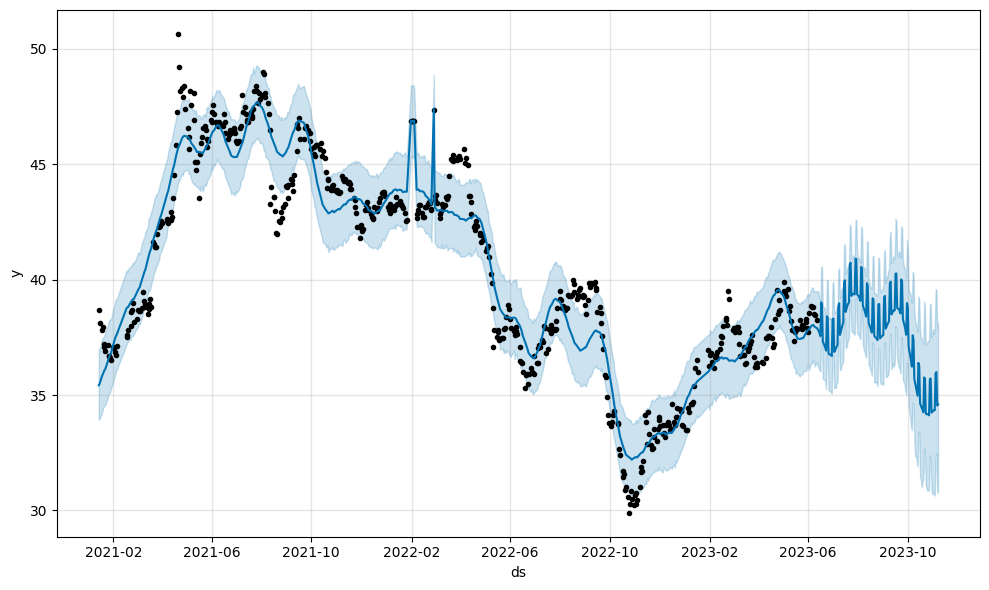

In [12]:
model = train_prophet_model(train_df)
forecast = generate_forecast(model, len(test_df))
plot_forecast(model, forecast)

In [233]:
print("Train Data Range:", train_df["ds"].min(), "to", train_df["ds"].max())
print("Test Data Range:", test_df["ds"].min(), "to", test_df["ds"].max())
print("Forecast Data Range:", forecast["ds"].min(), "to", forecast["ds"].max())


Train Data Range: 2021-01-14 00:00:00 to 2023-06-12 00:00:00
Test Data Range: 2023-06-13 00:00:00 to 2024-01-12 00:00:00
Forecast Data Range: 2021-01-14 00:00:00 to 2023-11-07 00:00:00


In [234]:
test_df["ds"]

0     2023-06-13
1     2023-06-14
2     2023-06-15
3     2023-06-16
4     2023-06-19
         ...    
143   2024-01-08
144   2024-01-09
145   2024-01-10
146   2024-01-11
147   2024-01-12
Name: ds, Length: 148, dtype: datetime64[ns]

In [235]:
forecast["ds"][588:588+10]

588   2023-06-13
589   2023-06-14
590   2023-06-15
591   2023-06-16
592   2023-06-17
593   2023-06-18
594   2023-06-19
595   2023-06-20
596   2023-06-21
597   2023-06-22
Name: ds, dtype: datetime64[ns]

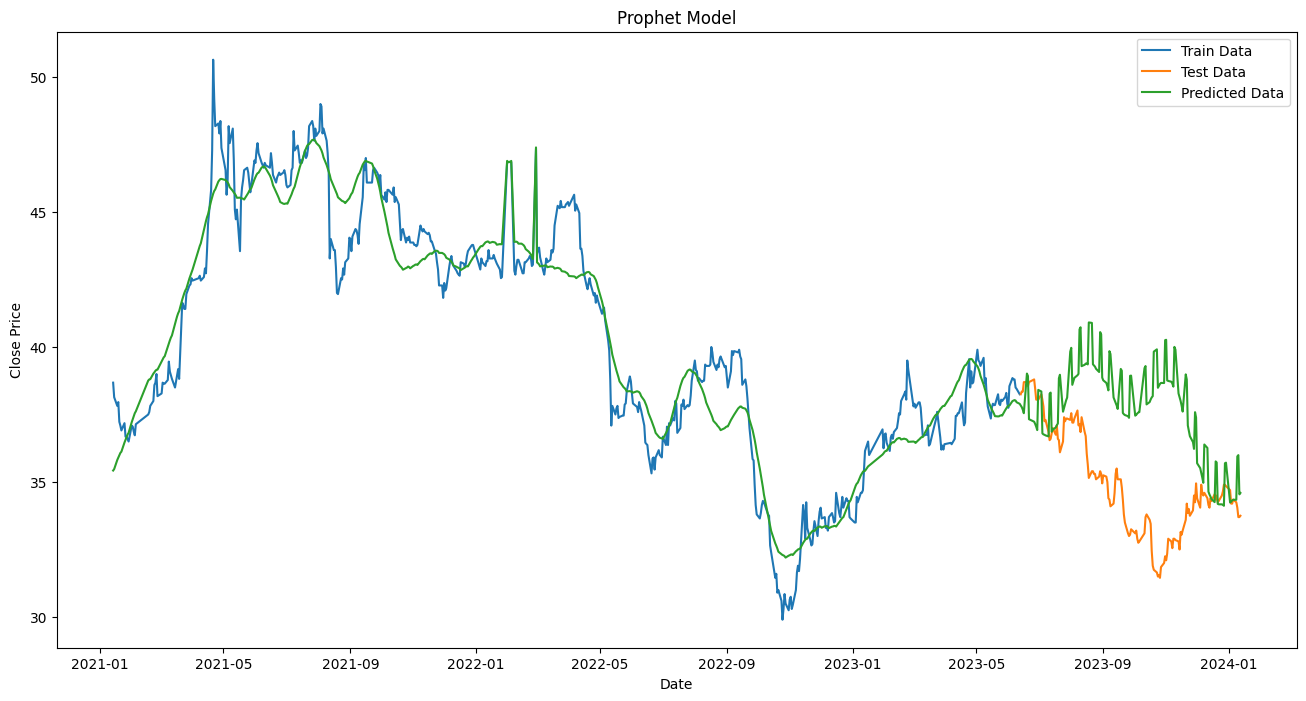

In [13]:
# 繪圖
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
plt.title('Prophet Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train_df["ds"], train_df["y"], label='Train Data')
plt.plot(test_df["ds"], test_df["y"], label='Test Data')
plt.plot(df["ds"], forecast["yhat"], label='Predicted Data')
plt.legend()
plt.show()

In [237]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def compute_rmse(test_df: pd.DataFrame, forecast: pd.DataFrame) -> float:
    rmse = sqrt(mean_squared_error(test_df["y"], forecast["yhat"][:len(test_df)]))
    return rmse

In [238]:
rmse = compute_rmse(test_df, forecast)
print(rmse)

10.280788526426997


### LSTM

In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [17]:
def preprocess_data(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
    df = df[["date", "close"]]
    df = df.sort_values(by="date", ascending=True).reset_index(drop=True)
    df.set_index("date", inplace=True)
    return df

In [18]:
data = preprocess_data(historical_df)

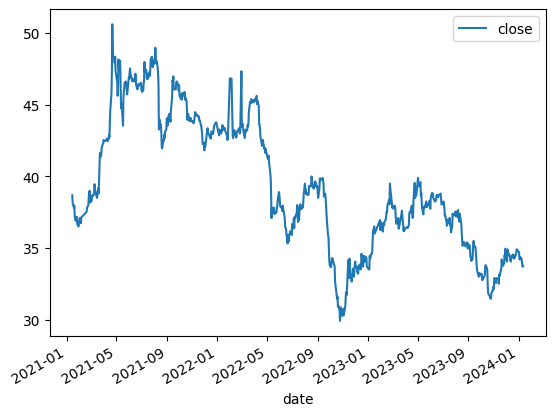

In [19]:
data.interpolate().plot()
plt.show()

In [20]:
data

,close
date,
2021-01-14,38.68
2021-01-15,38.14
2021-01-18,37.82
2021-01-19,37.96
2021-01-20,37.23
...,...
2024-01-08,34.25
2024-01-09,34.05
2024-01-10,33.70


In [21]:
scaler = MinMaxScaler(feature_range=(-1, 1))
data['close'] = scaler.fit_transform(data['close'].values.reshape(-1,1))

In [22]:
data

,close
date,
2021-01-14,-0.153327
2021-01-15,-0.205400
2021-01-18,-0.236258
2021-01-19,-0.222758
2021-01-20,-0.293153
...,...
2024-01-08,-0.580521
2024-01-09,-0.599807
2024-01-10,-0.633558


In [23]:
from typing import List

def split_data(stock: pd.DataFrame, look_back: int = 90) -> List[pd.DataFrame]:
    data_raw = stock.values
    data = []
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size) 
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    x_test  = data[train_set_size:,:-1,:]
    y_test  = data[train_set_size:,-1,:]
    return [x_train,y_train,x_test,y_test]

In [24]:
len(data)

736

In [38]:
lock_days = 90
x_train, y_train, x_test, y_test = split_data(data, lock_days)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (517, 89, 1)
y_train.shape =  (517, 1)
x_test.shape =  (129, 89, 1)
y_test.shape =  (129, 1)


In [39]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

y_train.size(),x_train.size()

(torch.Size([517, 1]), torch.Size([517, 89, 1]))

In [40]:
n_steps = lock_days - 1
batch_size = 1606
num_epochs = 2000

In [41]:
train = torch.utils.data.TensorDataset(x_train,y_train)
test = torch.utils.data.TensorDataset(x_test,y_test)
train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [42]:
# Build model
#####################
input_dim = 1
hidden_dim = 64
num_layers = 2 
output_dim = 1
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

In [43]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss(size_average=True)

optimiser = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
10
torch.Size([256, 1])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([256, 64])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([1, 64])
torch.Size([1])


/home/ya/.local/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [44]:
# train model
hist = np.zeros(num_epochs)
seq_dim = n_steps
for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.06336493045091629
Epoch  20 MSE:  0.017169548198580742
Epoch  30 MSE:  0.008700828067958355
Epoch  40 MSE:  0.006504037883132696
Epoch  50 MSE:  0.005620968993753195
Epoch  60 MSE:  0.005127924494445324
Epoch  70 MSE:  0.004823759198188782
Epoch  80 MSE:  0.004644898697733879
Epoch  90 MSE:  0.004485117271542549
Epoch  100 MSE:  0.0043459744192659855
Epoch  110 MSE:  0.004220457747578621
Epoch  120 MSE:  0.004105049651116133
Epoch  130 MSE:  0.0040000504814088345
Epoch  140 MSE:  0.0039049657061696053
Epoch  150 MSE:  0.003819106612354517
Epoch  160 MSE:  0.0037419069558382034
Epoch  170 MSE:  0.0036727534607052803
Epoch  180 MSE:  0.0036111443769186735
Epoch  190 MSE:  0.0035563998389989138
Epoch  200 MSE:  0.0035078637301921844
Epoch  210 MSE:  0.003464894136413932
Epoch  220 MSE:  0.0034268773160874844
Epoch  230 MSE:  0.00339324027299881
Epoch  240 MSE:  0.003363455645740032
Epoch  250 MSE:  0.0033370545133948326
Epoch  260 MSE:  0.003313615918159485
Epoch  270 MS

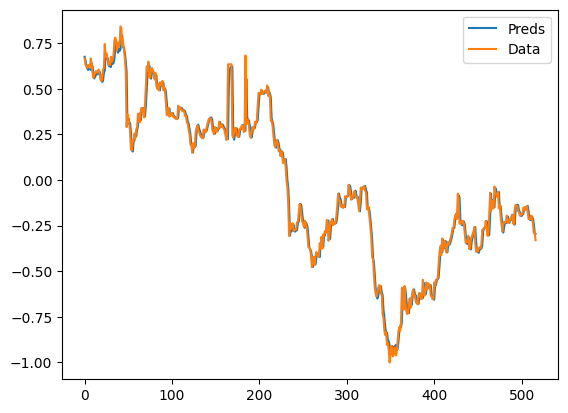

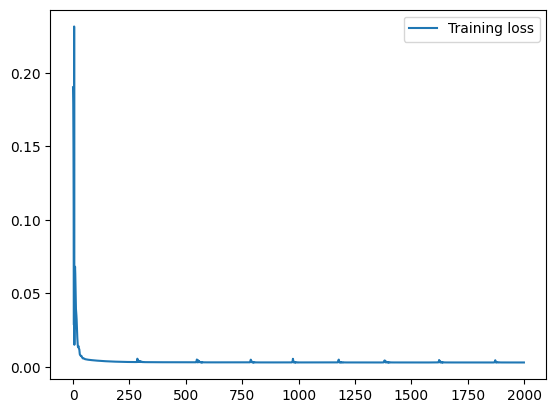

In [45]:
plt.plot(y_train_pred.detach().numpy(), label="Preds")
plt.plot(y_train.detach().numpy(), label="Data")
plt.legend()
plt.show()

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [46]:
# 預測
model.eval()
train_predict = model(x_train).detach().numpy()
test_predict = model(x_test).detach().numpy()


In [47]:
# 反正規化
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


In [48]:
# 計算 RMSE
train_rmse = np.sqrt(np.mean(((train_predict - scaler.inverse_transform(y_train.reshape(-1, 1))) ** 2)))
test_rmse = np.sqrt(np.mean(((test_predict - scaler.inverse_transform(y_test.reshape(-1, 1))) ** 2)))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 0.5692280413340549
Test RMSE: 0.33664053929752946


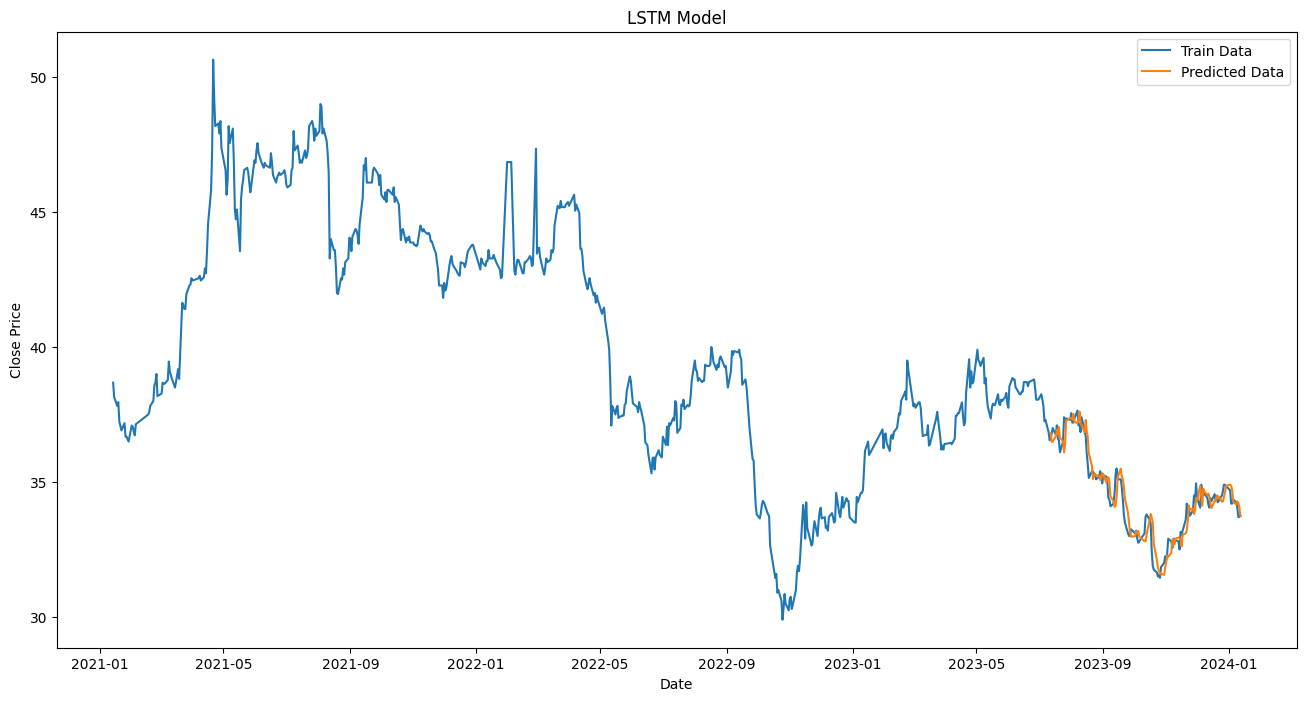

In [49]:
# 繪圖
train_data_len = len(x_train)
plt.figure(figsize=(16, 8))
plt.title('LSTM Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(data.index[:], scaler.inverse_transform(data), label='Train Data')
plt.plot(data.index[train_data_len + lock_days:], test_predict, label='Predicted Data')
plt.legend()
plt.show()

